In [ ]:
# === Environment Setup ===
import sys, subprocess, importlib

def ensure(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        return importlib.import_module(import_name)
    except ModuleNotFoundError:
        print(f"Installing {pkg_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-U", pkg_name])
        return importlib.import_module(import_name)

kt = ensure("keras-tuner", "keras_tuner")

import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("KerasTuner:", kt.__version__)


Installing keras-tuner ...
TensorFlow: 2.19.0
KerasTuner: 1.4.7


In [ ]:
# === Config & Load Augmented Dataset (handles NaNs/rare classes) ===
import os
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import joblib
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----- Path to augmented dataset -----
AUG_CSV_PATH = "./augmented_normal_data.csv"

# Load CSV
df_aug = pd.read_csv(AUG_CSV_PATH)
print("Columns:", list(df_aug.columns))

# Identify label column
label_col_candidates = [c for c in df_aug.columns if c.lower() in ["classid", "label"]]
assert len(label_col_candidates) >= 1, "Could not find a label column named 'classID' or 'label' in the CSV."
LABEL_COL = label_col_candidates[0]

# Coerce label column to numeric
df_aug[LABEL_COL] = pd.to_numeric(df_aug[LABEL_COL], errors="coerce")

# Drop rows with NaN labels (these break stratification)
nan_label_count = df_aug[LABEL_COL].isna().sum()
if nan_label_count > 0:
    print(f"Dropping {nan_label_count} row(s) with NaN label.")
    df_aug = df_aug.dropna(subset=[LABEL_COL])

# Cast labels to int (e.g., 0.0 -> 0)
df_aug[LABEL_COL] = df_aug[LABEL_COL].astype(int)

# If any class has < 2 samples, drop those rows (required for stratify)
label_counts = df_aug[LABEL_COL].value_counts().sort_index()
rare_classes = label_counts[label_counts < 2].index.tolist()
if len(rare_classes) > 0:
    print(f"Dropping classes with <2 samples (cannot stratify): {rare_classes}")
    df_aug = df_aug[~df_aug[LABEL_COL].isin(rare_classes)]

# Recompute counts after cleaning
label_counts = df_aug[LABEL_COL].value_counts().sort_index()
print("Label counts after cleaning:", label_counts.to_dict())

# Feature columns = all numeric columns except label
feature_cols = [c for c in df_aug.columns if c != LABEL_COL and pd.api.types.is_numeric_dtype(df_aug[c])]
assert len(feature_cols) > 0, "No numeric feature columns found."

X_all = df_aug[feature_cols].to_numpy(dtype=np.float32)
y_raw = df_aug[LABEL_COL].to_numpy()

print(f"Loaded {X_all.shape[0]} examples, feature_dim={X_all.shape[1]}")
print(f"Label column: {LABEL_COL}")
print("Label sample counts:", Counter(y_raw))

# Encode labels to integers 0..K-1
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Classes (encoder order):", list(le.classes_))

# One-hot for training with softmax
y_all = to_categorical(y_int, num_classes=num_classes)

# Stratified split: train/val/test = 70/10/20
X_train, X_tmp, y_train, y_tmp, yint_train, yint_tmp = train_test_split(
    X_all, y_all, y_int, test_size=0.30, random_state=SEED, stratify=y_int
)
X_val, X_test, y_val, y_test, yint_val, yint_test = train_test_split(
    X_tmp, y_tmp, yint_tmp, test_size=(2/3), random_state=SEED, stratify=yint_tmp
)

print("Splits:", X_train.shape, X_val.shape, X_test.shape)

# Scale features (fit on train only) — no leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Save artifacts
os.makedirs("../Artifacts", exist_ok=True)
joblib.dump(scaler, '../Artifacts/lstm_standard_scaler.pkl')
joblib.dump(le,     '../Artifacts/lstm_label_encoder.pkl')

# Reshape to (N, T, 1) so LSTM sees a "sequence" of length=feature_dim
T = X_train.shape[1]
X_train = X_train.reshape((-1, T, 1))
X_val   = X_val.reshape((-1, T, 1))
X_test  = X_test.reshape((-1, T, 1))

input_shape = (T, 1)
output_units = num_classes

# Class weights
class_weights_vec = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(yint_train),
    y=yint_train
)
class_weights = {i: float(w) for i, w in enumerate(class_weights_vec)}
print("Class weights:", class_weights)


Columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', 'label']
Label counts after cleaning: {0: 5000, 1: 2145, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 1870, 7: 5000, 8: 4645, 9: 5000}
Loaded 43660 examples, feature_dim=128
Label column: label
Label sample cou

In [ ]:
# === HyperModel for KerasTuner ===
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

class LSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape, output_units):
        self.input_shape = input_shape
        self.output_units = output_units

    def build(self, hp):
        bidir = hp.Boolean("bidirectional", default=True)

        units_1 = hp.Int("units_1", min_value=64, max_value=256, step=32)
        units_2 = hp.Int("units_2", min_value=64, max_value=256, step=32)
        dropout_1 = hp.Float("dropout_1", min_value=0.0, max_value=0.6, step=0.1, default=0.3)
        dropout_2 = hp.Float("dropout_2", min_value=0.0, max_value=0.6, step=0.1, default=0.3)

        dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32, default=64)
        lr = hp.Choice("lr", values=[5e-4, 1e-3, 2e-3], default=1e-3)

        model = Sequential()
        if bidir:
            model.add(Bidirectional(LSTM(units_1, return_sequences=True), input_shape=self.input_shape))
        else:
            model.add(LSTM(units_1, return_sequences=True, input_shape=self.input_shape))
        model.add(Dropout(dropout_1))

        if bidir:
            model.add(Bidirectional(LSTM(units_2)))
        else:
            model.add(LSTM(units_2))
        model.add(Dropout(dropout_2))

        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(self.output_units, activation='softmax'))

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [ ]:
# === Tuner setup & search ===
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for tuner training
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

hypermodel = LSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Directory to store tuner trials
os.makedirs("../Results/kt_runs", exist_ok=True)

tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory="../Results/kt_runs",
    project_name="lstm_aug",
    overwrite=True
)

tuner.search_space_summary()

# Fixed batch size
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

tuner.results_summary(num_trials=5)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best HPs:", best_hp.values)


Trial 10 Complete [00h 06m 38s]
val_accuracy: 0.7869904041290283

Best val_accuracy So Far: 0.937242329120636
Total elapsed time: 02h 42m 52s
Results summary
Results in ../Results/kt_runs/lstm_aug
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
bidirectional: True
units_1: 96
units_2: 256
dropout_1: 0.1
dropout_2: 0.4
dense_units: 128
lr: 0.001
Score: 0.937242329120636

Trial 08 summary
Hyperparameters:
bidirectional: True
units_1: 96
units_2: 192
dropout_1: 0.2
dropout_2: 0.2
dense_units: 64
lr: 0.001
Score: 0.926477313041687

Trial 07 summary
Hyperparameters:
bidirectional: True
units_1: 64
units_2: 192
dropout_1: 0.1
dropout_2: 0.1
dense_units: 128
lr: 0.0005
Score: 0.9099862575531006

Trial 00 summary
Hyperparameters:
bidirectional: False
units_1: 192
units_2: 192
dropout_1: 0.4
dropout_2: 0.1
dense_units: 96
lr: 0.001
Score: 0.8996793627738953

Trial 04 summary
Hyperparameters:
bidirectional: True
units_1: 256
units_2: 96
dr

In [ ]:
# === Retrain best model on Train+Val; keep a tiny internal validation split for early stopping ===
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Rebuild the model from best HP
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

# Merge train+val for final training (common practice after tuning)
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

early_stopping_final = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = best_model.fit(
    X_train_full, y_train_full,
    validation_split=0.1,      # small internal val to guide early stopping
    epochs=120,
    batch_size=128,
    callbacks=[early_stopping_final, reduce_lr_final],
    class_weight=class_weights,
    verbose=1
)

# Save best model & hyperparams
os.makedirs("../Models", exist_ok=True)
best_model.save("../Models/best_lstm_from_aug.keras")

hp_items = sorted(best_hp.values.items(), key=lambda x: x[0])
hp_df = pd.DataFrame(hp_items, columns=["Hyperparameter", "Value"])
hp_df.to_csv("../Results/best_lstm_hyperparameters.csv", index=False)

print("Saved model and hyperparameters.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128, 192)       │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │       919,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,061,770 (4.05 MB)

 Trainable params: 1,061,770 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.3022 - loss: 1.9356 - val_accuracy: 0.4601 - val_loss: 1.5425 - learning_rate: 0.0010
Epoch 2/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.4338 - loss: 1.5699 - val_accuracy: 0.5442 - val_loss: 1.3244 - learning_rate: 0.0010
Epoch 3/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.4901 - loss: 1.4041 - val_accuracy: 0.5817 - val_loss: 1.2005 - learning_rate: 0.0010
Epoch 4/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.5287 - loss: 1.3002 - val_accuracy: 0.6109 - val_loss: 1.1181 - learning_rate: 0.0010
Epoch 5/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.5642 - loss: 1.2018 - val_accuracy: 0.6450 - val_loss: 1.0520 - learning_rate: 0.0010
Epoch 6/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.5944 - loss: 1.1166 - val_accuracy: 0.6645 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 7/120
246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.6

FINAL Test accuracy: 0.9433 | Test loss: 0.2005


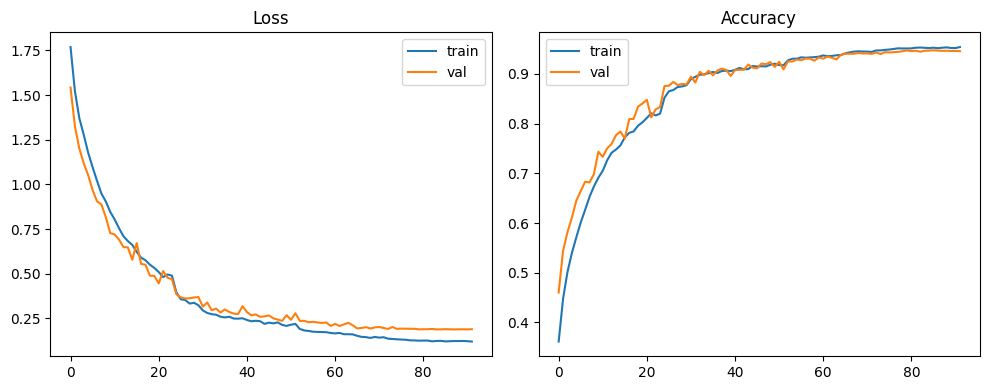

              precision    recall  f1-score   support

           0     0.9516    0.9840    0.9676      1000
           1     0.9607    0.9697    0.9652       429
           2     0.8902    0.8590    0.8743      1000
           3     0.9718    0.8970    0.9329      1000
           4     0.9627    0.9800    0.9713      1000
           5     0.9499    0.9670    0.9584      1000
           6     0.9464    0.9920    0.9687       374
           7     0.9869    0.9780    0.9824      1000
           8     0.8845    0.9483    0.9153       929
           9     0.9397    0.9040    0.9215      1000

    accuracy                         0.9433      8732
   macro avg     0.9445    0.9479    0.9458      8732
weighted avg     0.9437    0.9433    0.9431      8732



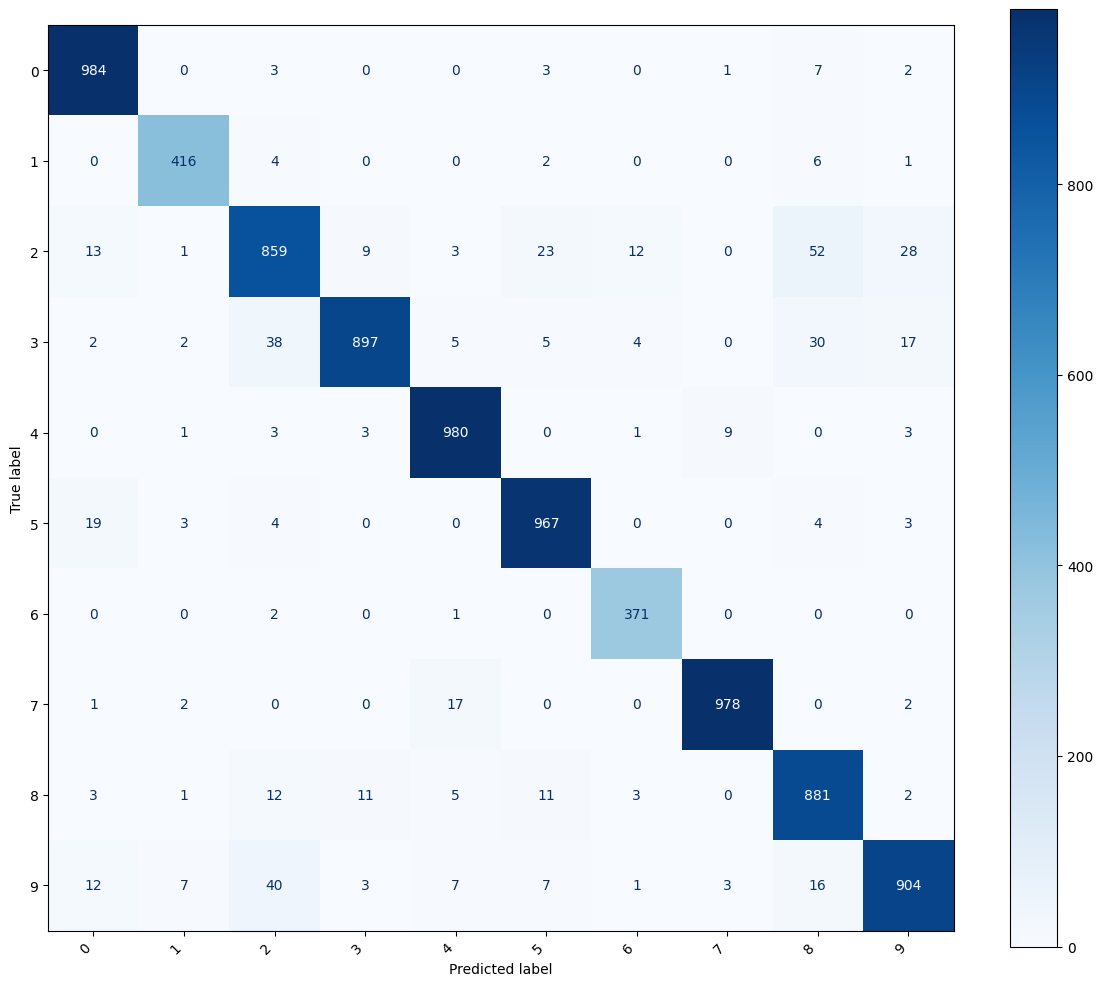

In [ ]:
# === Final Test Evaluation & Reports ===
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"FINAL Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.title('Loss'); plt.legend(['train','val'])
plt.subplot(1,2,2); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.title('Accuracy'); plt.legend(['train','val'])
plt.tight_layout(); plt.show()

# Predictions (argmax for softmax multiclass)
y_prob = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Class names from LabelEncoder
class_names = [str(c) for c in le.classes_]

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout(); plt.show()
